In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
import tensorflow
print (tensorflow.__version__)

2.3.1


Training data shapes: X=(60000, 28, 28), y=(60000,)
Testing data shapes: X=(10000, 28, 28), y=(10000,)


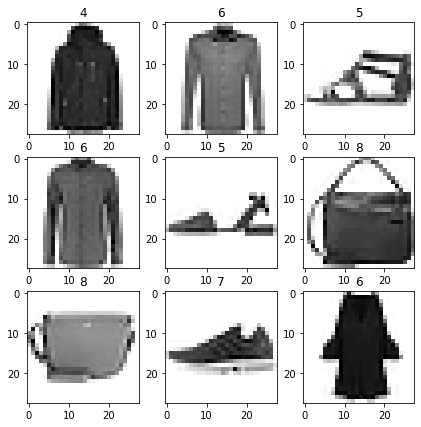

In [3]:
from tensorflow.keras.datasets import fashion_mnist, mnist

(trainX, trainY), (testX, testY) = fashion_mnist.load_data()

print('Training data shapes: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Testing data shapes: X=%s, y=%s' % (testX.shape, testY.shape))

plt.figure(figsize=(7, 7))
for j in range(9):
    i = np.random.randint(0, 10000)
    plt.subplot(330 + 1 + j)
    plt.imshow(trainX[i], cmap='gray_r')
    plt.title(trainY[i])
plt.show()

In [4]:
trainX = [image/255 for image in trainX]
testX = [image/255 for image in testX]

trainX = np.reshape(trainX, (60000, 28, 28, 1))
testX = np.reshape(testX, (10000, 28, 28, 1))

print (trainX.shape, testX.shape, trainY.shape, testY.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1) (60000,) (10000,)


# Generator Model (U-Net Like)

In [5]:
def encoder_layer(input_layer, filters, bn=True):
    x = tensorflow.keras.layers.Conv2D(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
    if bn:
        x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
    return x

def decoder_layer(input_layer, skip_input, filters):
    #x = tensorflow.keras.layers.UpSampling2D(size=2)(input_layer)
    x = tensorflow.keras.layers.Conv2DTranspose(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.Activation('relu')(x)
    x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
    x = tensorflow.keras.layers.Concatenate()([x, skip_input])
    return x

In [6]:
source_image_A = tensorflow.keras.layers.Input(shape=(256, 256, 3))
source_image_B = tensorflow.keras.layers.Input(shape=(256, 256, 3))
source_image = tensorflow.keras.layers.Input(shape=(256, 256, 3))

e1 = encoder_layer(source_image, 32, bn=False)
e2 = encoder_layer(e1, 64)
e3 = encoder_layer(e2, 128)
e4 = encoder_layer(e3, 256)
e5 = encoder_layer(e4, 256)
e6 = encoder_layer(e5, 256)
e7 = encoder_layer(e6, 256)

bottle_neck = tensorflow.keras.layers.Conv2D(512, (4,4), strides=(2,2), padding='same')(e7)
b = tensorflow.keras.layers.Activation('relu')(bottle_neck)

d1 = decoder_layer(b, e7, 256)
d2 = decoder_layer(d1, e6, 256)
d3 = decoder_layer(d2, e5, 256)
d4 = decoder_layer(d3, e4, 256)
d5 = decoder_layer(d4, e3, 256)
d6 = decoder_layer(d5, e2, 64)
d7 = decoder_layer(d6, e1, 32)

decoded = tensorflow.keras.layers.Conv2DTranspose(3, kernel_size=(4,4), strides=(2,2), padding='same')(d7)
translated_image = tensorflow.keras.layers.Activation('tanh')(decoded)

generator_network_AB = tensorflow.keras.models.Model(inputs=source_image, outputs=translated_image)
generator_network_BA = tensorflow.keras.models.Model(inputs=source_image, outputs=translated_image)

print (generator_network_AB.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 1568        input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128, 128, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   32832       leaky_re_lu[0][0]                
_______________________________________________________________________________________

# Discriminator Network

In [7]:
def my_conv_layer(input_layer, filters, bn=True):
    x = tensorflow.keras.layers.Conv2D(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
    if bn:
        x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
    return x

In [8]:
target_image_input = tensorflow.keras.layers.Input(shape=(256, 256, 3))

x = my_conv_layer(target_image_input, 64, bn=False)
x = my_conv_layer(x, 128)
x = my_conv_layer(x, 256)
x = my_conv_layer(x, 512)

patch_features = tensorflow.keras.layers.Conv2D(1, kernel_size=(4,4), strides=(1,1), padding='same')(x)

discriminator_network_A = tensorflow.keras.models.Model(inputs=target_image_input, outputs=patch_features)
discriminator_network_B = tensorflow.keras.models.Model(inputs=target_image_input, outputs=patch_features)

print (discriminator_network_A.summary())

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 128, 64)      3136      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 128)       131200    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 64, 64, 128)       512       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 256)      

In [9]:
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_network_A.compile(loss='mse', optimizer=adam_optimizer, metrics=['accuracy'])
discriminator_network_A.compile(loss='mse', optimizer=adam_optimizer, metrics=['accuracy'])

# Cycle-GAN

In [10]:
# Domain Transfer
fake_B = generator_network_AB(source_image_A)
fake_A = generator_network_BA(source_image_B)

# Restoring original Domain
get_back_A = generator_network_BA(fake_B)
get_back_B = generator_network_AB(fake_A)

# Get back Identical/Same Image
get_same_A = generator_network_BA(source_image_A)
get_same_B = generator_network_AB(source_image_B)
  
discriminator_network_A.trainable=False
discriminator_network_B.trainable=False

# Tell Real vs Fake, for a given domain
verify_A = discriminator_network_A(fake_A)
verify_B = discriminator_network_B(fake_B)

cycle_gan = tensorflow.keras.models.Model(inputs = [source_image_A, source_image_B], \
                              outputs = [verify_A, verify_B, get_back_A, get_back_B, get_same_A, get_same_B])
cycle_gan.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
functional_3 (Functional)       (None, 256, 256, 3)  16893635    input_2[0][0]                    
                                                                 functional_1[0][0]               
                                                                 input_1[0][0]                    
_______________________________________________________________________________________

# Compiling Models

In [11]:
cycle_gan.compile(loss=['mse', 'mse', 'mae', 'mae', 'mae', 'mae'], loss_weights=[1, 1, 10, 10, 1, 1],\
                                          optimizer=adam_optimizer)

# Define Data Generators

In [12]:
indices = [i for i in range(0, len(trainX))]

def get_batches_of_domains(batch_size):
    domain_A_images = []
    domain_B_images = []
    return domain_A_images, domain_B_images

def show_generator_results(generator_network_AB, generator_network_BA):
    domain_A_images, domain_B_images = get_batches_of_domains(10)
    
    fake_B_images = generator_network_AB(domain_A_images)
    fake_A_images = generator_network_BA(domain_B_images)

    plt.figure(figsize=(7, 7))
    for j in range(5):
        i = j
        plt.subplot(550 + 1 + j)
        plt.imshow(fake_A_images[i,:,:,-1], cmap='gray')
    plt.show()
    
    plt.figure(figsize=(7, 7))
    for j in range(5):
        i = j
        plt.subplot(550 + 1 + j)
        plt.imshow(fake_B_images[i,:,:,-1], cmap='gray')
    plt.show()
    return

# Training GAN

In [13]:
epochs = 500
batch_size = 100
steps = 500
noise_size = 500

for i in range(0, epochs):
    if (i%10 == 0):
        op = show_generator_results(generator_network_AB, generator_network_BA)
        #print (op)
    for j in range(steps):
        domain_A_images, domain_B_images = get_batches_of_domains(batch_size)

        fake_patch = np.zeros((batch_size, 16, 16, 1))
        real_patch = np.ones((batch_size, 16, 16, 1))
        
        fake_B_images = generator_network_AB(domain_A_images)
        fake_A_images = generator_network_BA(domain_B_images)
        
        # Updating Discriminator A weights
        discriminator_network_A.trainable=True
        loss_d_real_A = discriminator_network_A.train_on_batch(domain_A_images, real_patch)
        loss_d_fake_A = discriminator_network_A.train_on_batch(fake_A_images, fake_patch)
        
        loss_d_A = np.add(loss_d_real_A, loss_d_fake_A)/2.0
        
        # Updating Discriminator B weights
        discriminator_network_B.trainable=True
        loss_d_real_B = discriminator_network_B.train_on_batch(domain_B_images, real_patch)
        loss_d_fake_B = discriminator_network_B.train_on_batch(fake_B_images, fake_patch)
        
        loss_d_B = np.add(loss_d_real_B, loss_d_fake_B)/2.0
        
        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        
        discriminator_network_A.trainable=False
        discriminator_network_B.trainable=False
        
        # Updating Generator weights
        loss_g = cycle_gan.train_on_batch([domain_A_images, domain_B_images],\
                    [real_patch, real_patch, domain_A_images, domain_B_images, domain_A_images, domain_B_images])
        
        if j%50 == 0:
            print ("Epoch:%.0f, Step:%.0f, DA-Loss:%.3f, DA-Acc:%.3f, DB-Loss:%.3f, DB-Acc:%.3f, G-Loss:%.3f"\
                   %(i,j,loss_d_A[0],loss_d_A[1]*100,loss_d_B[0],loss_d_B[1]*100,loss_g[0]))
            

AssertionError: Could not compute output Tensor("activation_8/Tanh:0", shape=(None, 256, 256, 3), dtype=float32)

In [5]:
!wget https://www.kaggle.com/jessicali9530/celeba-dataset/download

dyld: Library not loaded: /usr/local/opt/openssl/lib/libssl.1.0.0.dylib
  Referenced from: /usr/local/bin/wget
  Reason: image not found
